Test the CNN Multigrid on a model problem: f(x,y) = 0

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

from FEANet.mesh import MeshCircInterface
from FEANet.geo import Geometry
from FEANet.jacobi import JacobiBlock
from FEANet.model import KNet, FNet
from Utils import plot

In [2]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    Note: the n should be the number of intervals, e.g., 
          there are (n+1)*(n+1) grid points in total if the size is n
          f has already been convoluted, i.e., f = fnet(ff) if ff is the sourcing term of PDE
    '''
    def __init__(self, size, n):
        self.size = size # actual size of the plate
        self.n = n 
        self.omega = 2/3.
        self.property = [1, 1] # homogeneous problem
        self.plate = Geometry(nnode_edge = n+1)
        self.grid = MeshCircInterface(size, prop=self.property, nnode_edge=n+1)
        self.v = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.f = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.InstantiateFEANet()
        self.jac = JacobiBlock(self.Knet, self.grid, self.omega, self.plate.geometry_idx, self.plate.boundary_value)

    def IsCoarsest(self):
        return self.n == 2
        
    def InstantiateFEANet(self):
        self.Knet = KNet(self.grid) # Initialize the stiffness network, given mesh
        self.fnet = FNet(self.size/self.n) # Initialize the forcing term network, given mesh size
        for param in self.Knet.parameters():
            param.requires_grad = False
        for param in self.fnet.parameters():
            param.requires_grad = False

    def Relax(self, num_sweeps_down):
        '''
        Perform a fixed number of weighted Jacobi iteration
        Return: error array with size of (num_sweeps_down,)
        '''
        self.v = self.jac.jacobi_convolution(self.v, self.f, n_iter=num_sweeps_down)


In [92]:
class Multigrid():
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, n = 64, final_level = None):
        self.size = 2
        self.n = n # total number of grids for finest grid
        if(final_level is None):
            self.L = int(np.log2(n)) # number of levels for V-cycle multigrid
        else:
            self.L = final_level

        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids
        
        self.initial_v = torch.from_numpy(self.random_data())
        self.grids[0].f =  torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)

    def GridDict(self):
        grids = {}
        for i in range(self.L):
            grids[i] = SingleGrid(self.size, self.n_arr[i])
        return grids

    def SizeArray(self):
        n_arr = []
        for i in range(self.L):
            n_arr.append(int(self.n/(2.**i)))
        n_arr = np.array(n_arr)
        return n_arr

    def Restrict(self, f):
        '''
        Perform full weighting operation to down sample to next level
        '''
        f_res = f[:, :, 1:-1, 1:-1]
        restriction_kernel = torch.asarray([[1, 2, 1],
                                            [2, 4, 2],
                                            [1, 2, 1]], dtype=torch.float32) / 16.0

        f_res = F.conv2d(f_res, restriction_kernel.view(1, 1, 3, 3), stride=2)
        return F.pad(f_res,(1,1,1,1),"constant",0) # pad with zeros

    def Interpolate(self, v):
        '''
        Perform linear interpolation and upsample to previous level ==> Return size: (2*N - 1), Ex. 17 -> 33
        '''
        _, _, image_size, _ = v.shape
        new_size = 2 * image_size - 1
        v = F.interpolate(v, size=new_size, mode='bilinear', align_corners=True)
        level = np.where(self.n_arr == new_size-1)[0][0]
        return self.grids[level].jac.reset_boundary(v)
    
    def rec_V_cycle(self, l, v, f):
        '''
        Perform recursive V-cycle
        Input: l, current level
        '''
        self.grids[l].v = v
        self.grids[l].f = f
        self.grids[l].Relax(self.v1)
        if(l < self.L-1):
            residual = self.grids[l].f-self.grids[l].Knet(self.grids[l].v)
            self.grids[l+1].f = 4*self.Restrict(residual)
            self.grids[l+1].v *= 0.
            self.rec_V_cycle(l+1, self.grids[l+1].v, self.grids[l+1].f)
            self.grids[l].v += self.Interpolate(self.grids[l+1].v)
            self.grids[l+1].v *= 0.
        
        self.grids[l].Relax(self.v2) 

    def V_cycle(self, x, f):
        '''Input x is the initial solution on the finest grid'''
        n_batches = x.shape[0]
        self.grids[0].v = x
        self.grids[0].f = f
        
        for j in range(0, self.L-1):
            self.grids[j].Relax(self.v1)
            rF = self.grids[j].f-self.grids[j].Knet(self.grids[j].v)
            self.grids[j+1].f = 4*self.Restrict(rF)
            self.grids[j+1].v *= 0.

        self.grids[self.L-1].Relax(self.v1+self.v2)

        for j in range(self.L-2,-1,-1):
            eFC = self.grids[j+1].v
            eF_delta = self.Interpolate(eFC)
            self.grids[j].v = self.grids[j].v + eF_delta
            self.grids[j].Relax(self.v2)

            # zero out the previous level solution
            self.grids[j+1].v *= 0. 

    def random_data(self):
        coef = 100000 + 50000*np.random.rand(2)
        return coef[0]*np.random.random((self.n+1,self.n+1)).astype('f') + coef[1]

    def Solve(self, v1v2=[1,1], rec = True, n_iter=None, EPS=None):        
        if (n_iter is None):
            if(EPS is None):
                print("At least one of EPS and n_iter have to be assigned")
                return # 
            else:
                n_iter = 0
        else:
            if(EPS is None):
                EPS = np.inf

        n_Vcycle = 0
        res = 1
        res_arr_Vcycle = []

        self.v1, self.v2 = v1v2
        self.grids[0].v = self.initial_v
        while (res > EPS or n_Vcycle < n_iter):
            u_prev = self.grids[0].v 
            if(rec is True):
                self.rec_V_cycle(0,self.grids[0].v,self.grids[0].f)
            else:
                self.V_cycle(self.grids[0].v,self.grids[0].f)
            residual = self.grids[0].f-self.grids[0].Knet(self.grids[0].v)
            res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
            res_arr_Vcycle.append(res)
            #print(n_Vcycle, res)
            n_Vcycle += 1

        #print("Solution converges after", n_Vcycle, "V-cycle iterations")
        return res_arr_Vcycle

    def solve_jacobi(self, n_iter=None, EPS=None):
        if (n_iter is None):
            if(EPS is None):
                print("At least one of EPS and n_iter have to be assigned")
                return # 
            else:
                n_iter = 0
        else:
            if(EPS is None):
                EPS = np.inf

        n_jacobi = 0
        self.grids[0].v = self.initial_v
        res_arr_jacobi = []
        res = 1
        while (res > EPS or n_jacobi < n_iter):
            self.grids[0].Relax(1)
            residual = self.grids[0].f-self.grids[0].Knet(self.grids[0].v)
            res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
            res_arr_jacobi.append(res)
            #print(res)
            n_jacobi += 1

        #print("Solution converges after", n_jacobi, "Weighted Jacobi iterations")
        return res_arr_jacobi

In [39]:
def compute_q(res_arr, m = None):
    if(m is None):
        return res_arr[-1]/res_arr[-2]
    else:
        return res_arr[m]/res_arr[m-1]

In [99]:
# test the convergence factor when change the grid size
size_list = [1,2,3,4,5,6,7,8,9]
for size in size_list:
    n = 2**size
    prob_mg = Multigrid(n)
    res_vcycle = prob_mg.Solve([1,1], EPS=1e-6)
    print("Convergence factor for n=2^" + str(size)+ " is:", compute_q(res_vcycle))

Convergence factor for n=2^1 is: 0.11111108994284451
Convergence factor for n=2^2 is: 0.20348727322155963
Convergence factor for n=2^3 is: 0.20894400912755484
Convergence factor for n=2^4 is: 0.23633170551474558
Convergence factor for n=2^5 is: 0.25214505253226477
Convergence factor for n=2^6 is: 0.2590017824721803
Convergence factor for n=2^7 is: 0.2621265096445177
Convergence factor for n=2^8 is: 0.2631096274749841
Convergence factor for n=2^9 is: 0.2633506183082224


In [96]:
# test the convergence factor when change the grid size (jacobi itaration)
size_list = [1,2,3,4,5,6,7,8,9]
for size in size_list:
    n = 2**size
    prob_jac = Multigrid(n)
    if (size < 5):
        res_jacobi = prob_jac.solve_jacobi(EPS=1e-5)
    else:
        res_jacobi = prob_jac.solve_jacobi(n_iter=2000)
    print("Convergence factor for n=2^" + str(size)+ " is:", compute_q(res_jacobi))

Convergence factor for n=2^1 is: 0.3333333116276344
Convergence factor for n=2^2 is: 0.7357022308245716
Convergence factor for n=2^3 is: 0.9258110070423765
Convergence factor for n=2^4 is: 0.9809084701532486
Convergence factor for n=2^5 is: 0.9951923219788481
Convergence factor for n=2^6 is: 0.9987957817119715
Convergence factor for n=2^7 is: 0.9996476148243258
Convergence factor for n=2^8 is: 0.9996256091500267
Convergence factor for n=2^9 is: 0.9996246440044934


In [78]:
# Multigrid implementation
n = 2**6
prob_mg = Multigrid(n)

0 40337.734375
1 13465.33203125
2 5276.84326171875
3 2249.56787109375
4 1003.1481323242188
5 458.79876708984375
6 213.1576385498047
7 100.10664367675781
8 47.39125061035156
9 22.575885772705078
10 10.808820724487305
11 5.196545124053955
12 2.5070395469665527
13 1.2130767107009888
14 0.5884547233581543
15 0.28608009219169617
16 0.13934484124183655
17 0.06798649579286575
18 0.03321997448801994
19 0.016253631561994553
20 0.00796188972890377
21 0.003904319368302822
22 0.0019164334516972303
23 0.0009415058302693069
24 0.0004629133327398449
25 0.00022776881814934313
26 0.0001121452369261533
27 5.525050437427126e-05
28 2.7235786546953022e-05
29 1.3433013918984216e-05
30 6.628578830714105e-06
31 3.2723955882829614e-06
32 1.6162040310518933e-06
33 7.98544931512879e-07
Solution converges after 34 V-cycle iterations
Convergence factor is: 0.49408670945657307


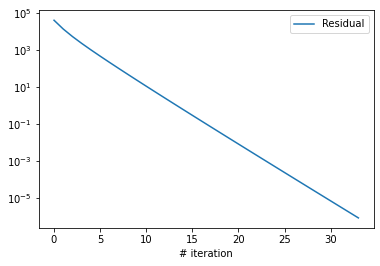

In [57]:
res_vcycle_v01 = prob_mg.Solve([0,1], rec = False, EPS=1e-6)

plt.plot(res_vcycle_v01, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
plt.legend()

print("Convergence factor is:", compute_q(res_vcycle_v01))

0 40337.734375
1 13465.33203125
2 5276.84326171875
3 2249.56787109375
4 1003.1481323242188
5 458.79876708984375
6 213.1576385498047
7 100.10664367675781
8 47.39125061035156
9 22.575885772705078
10 10.808820724487305
11 5.196545124053955
12 2.5070395469665527
13 1.2130767107009888
14 0.5884547233581543
15 0.28608009219169617
16 0.13934484124183655
17 0.06798649579286575
18 0.03321997448801994
19 0.016253631561994553
20 0.00796188972890377
21 0.003904319368302822
22 0.0019164334516972303
23 0.0009415058302693069
24 0.0004629133327398449
25 0.00022776881814934313
26 0.0001121452369261533
27 5.525050437427126e-05
28 2.7235786546953022e-05
29 1.3433013918984216e-05
30 6.628578830714105e-06
31 3.2723955882829614e-06
32 1.6162040310518933e-06
33 7.98544931512879e-07
Solution converges after 34 V-cycle iterations
Convergence factor is: 0.49408670945657307


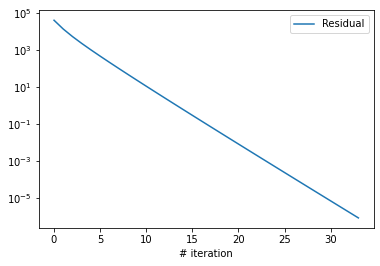

In [58]:
res_arr_v01 = prob_mg.Solve([0,1], EPS=1e-6)

plt.plot(res_arr_v01, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
plt.legend()

print("Convergence factor is:", compute_q(res_arr_v01))

0 40337.734375
1 13465.33203125
2 5276.84326171875
3 2249.56787109375
4 1003.1481323242188
5 458.79876708984375
6 213.1576385498047
7 100.10664367675781
8 47.39125061035156
9 22.575885772705078
10 10.808820724487305
11 5.196545124053955
12 2.5070395469665527
13 1.2130767107009888
14 0.5884547233581543
15 0.28608009219169617
16 0.13934484124183655
17 0.06798649579286575
18 0.03321997448801994
19 0.016253631561994553
20 0.00796188972890377
21 0.003904319368302822
22 0.0019164334516972303
23 0.0009415058302693069
24 0.0004629133327398449
25 0.00022776881814934313
26 0.0001121452369261533
27 5.525050437427126e-05
28 2.7235786546953022e-05
29 1.3433013918984216e-05
30 6.628578830714105e-06
31 3.2723955882829614e-06
32 1.6162040310518933e-06
33 7.98544931512879e-07
Solution converges after 34 V-cycle iterations
Convergence factor is: 0.49408670945657307


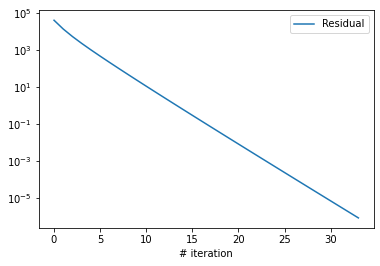

In [61]:
res_arr_v02 = prob_mg.Solve([0,1], EPS=1e-6)

plt.plot(res_arr_v02, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
plt.legend()

print("Convergence factor is:", compute_q(res_arr_v02))

0 40503.64453125
1 13606.8203125
2 5374.189453125
3 2309.910400390625
4 1038.267578125
5 478.4302673339844
6 223.8275146484375
7 105.78472137451172
8 50.36290740966797
9 24.110092163085938
10 11.591988563537598
11 5.592539310455322
12 2.7056519985198975
13 1.312004804611206
14 0.6374383568763733
15 0.31021004915237427
16 0.15117910504341125
17 0.07376836985349655
18 0.03603554517030716
19 0.017620841041207314
20 0.008624181151390076
21 0.004224477335810661
22 0.0020709296222776175
23 0.0010159499943256378
24 0.0004987402935512364
25 0.0002449935127515346
26 0.00012041970330756158
27 5.922287527937442e-05
28 2.914189826697111e-05
29 1.4347325304697733e-05
30 7.067046681186184e-06
31 3.4826412047550548e-06
32 1.7170132196042687e-06
33 8.468836085739895e-07
Solution converges after 34 V-cycle iterations
Convergence factor is: 0.49323068623151095


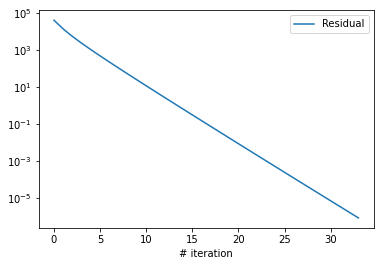

In [62]:
res_arr_v10 = prob_mg.Solve([1,0], EPS=1e-6)

plt.plot(res_arr_v10, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
plt.legend()

print("Convergence factor is:", compute_q(res_arr_v10))

0 13248.2998046875
1 2300.546142578125
2 485.86907958984375
3 108.92718505859375
4 25.113855361938477
5 5.8910746574401855
6 1.3986469507217407
7 0.33506977558135986
8 0.08084409683942795
9 0.01962013728916645
10 0.004785450175404549
11 0.0011723203351721168
12 0.000288323761196807
13 7.11676839273423e-05
14 1.762570536811836e-05
15 4.379151505418122e-06
16 1.0913155392699991e-06
17 2.7275854108665953e-07
Solution converges after 18 V-cycle iterations
Convergence factor is: 0.24993554226224315


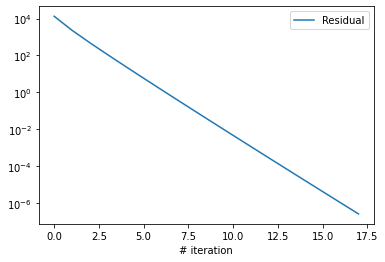

In [63]:
res_arr_v11 = prob_mg.Solve([1,1], EPS=1e-6)

plt.plot(res_arr_v11, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
plt.legend()

print("Convergence factor is:", compute_q(res_arr_v11))

0 5662.35693359375
1 564.9509887695312
2 64.98300170898438
3 7.930927276611328
4 1.0137486457824707
5 0.1351080983877182
6 0.0187115166336298
7 0.0026804625522345304
8 0.00039483438013121486
9 5.943296855548397e-05
10 9.091790161619429e-06
11 1.4073071952225291e-06
12 2.197183448515716e-07
Solution converges after 13 V-cycle iterations
Convergence factor is: 0.15612678283566145


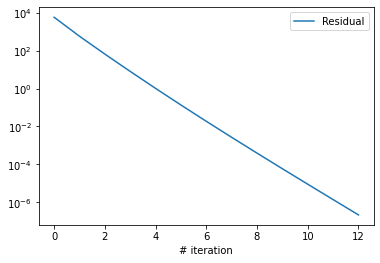

In [64]:
res_arr_v12 = prob_mg.Solve([1,2], EPS=1e-6)

plt.plot(res_arr_v12, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
plt.legend()

print("Convergence factor is:", compute_q(res_arr_v12))

0 15665.087890625
1 2881.397216796875
2 637.8015747070312
3 152.6185760498047
4 38.18247604370117
5 9.83834171295166
6 2.5850367546081543
7 0.687339186668396
8 0.18386656045913696
9 0.04927603155374527
10 0.013192687183618546
11 0.003522272687405348
12 0.0009368720930069685
13 0.00024815768119879067
14 6.545655196532607e-05
15 1.719679312373046e-05
16 4.5015353862254415e-06
17 1.1745495385184768e-06
18 3.0561000130546745e-07
Solution converges after 19 V-cycle iterations
Convergence factor is: 0.26019336884755834


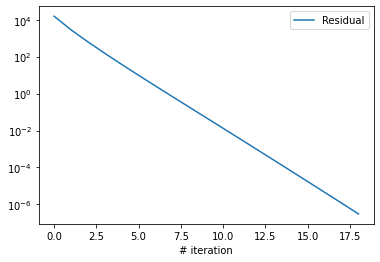

In [65]:
res_arr_v20 = prob_mg.Solve([2,0], EPS=1e-6)

plt.plot(res_arr_v20, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
plt.legend()

print("Convergence factor is:", compute_q(res_arr_v20))

0 5732.65869140625
1 578.5401611328125
2 67.61248016357422
3 8.438185691833496
4 1.109146237373352
5 0.15253877639770508
6 0.02181125245988369
7 0.003218882018700242
8 0.00048658568994142115
9 7.483830995624885e-05
10 1.1649563930404838e-05
11 1.828376639423368e-06
12 2.8857812139904127e-07
Solution converges after 13 V-cycle iterations
Convergence factor is: 0.15783297334735846


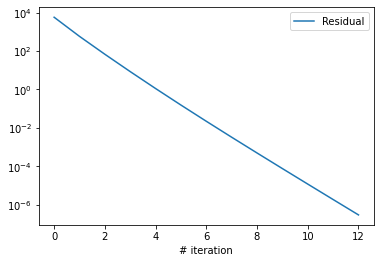

In [66]:
res_arr_v21 = prob_mg.Solve([2,1], EPS=1e-6)

plt.plot(res_arr_v21, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
plt.legend()

print("Convergence factor is:", compute_q(res_arr_v21))

0 2722.1005859375
1 167.6904296875
2 12.349136352539062
3 1.0386614799499512
4 0.09681675583124161
5 0.009654542431235313
6 0.001002285978756845
7 0.00010658937389962375
8 1.151277592725819e-05
9 1.2573204912769143e-06
10 1.3849729896264762e-07
Solution converges after 11 V-cycle iterations
Convergence factor is: 0.11015274142394038


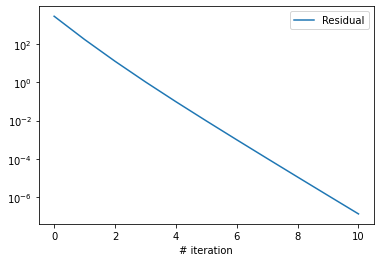

In [67]:
res_arr_v22 = prob_mg.Solve([2,2], EPS=1e-6)

plt.plot(res_arr_v22, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
plt.legend()

print("Convergence factor is:", compute_q(res_arr_v22))

0 2722.1005859375
1 167.6904296875
2 12.349136352539062
3 1.0386614799499512
4 0.09681675583124161
5 0.009654542431235313
6 0.001002285978756845
7 0.00010658937389962375
8 1.151277592725819e-05
9 1.2573204912769143e-06
10 1.3849729896264762e-07
Solution converges after 11 V-cycle iterations
Convergence factor is: 0.11015274142394038


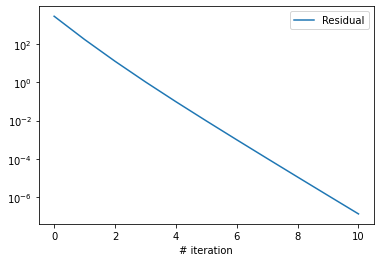

In [68]:
res_vcycle_v22 = prob_mg.Solve([2,2], rec = False, EPS=1e-6)

plt.plot(res_vcycle_v22, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
plt.legend()

print("Convergence factor is:", compute_q(res_vcycle_v22))

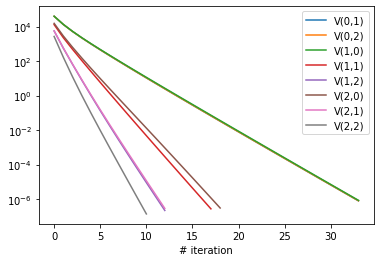

In [72]:
plt.plot(res_arr_v01, label='V(0,1)')
plt.plot(res_arr_v02, label='V(0,2)')
plt.plot(res_arr_v10, label='V(1,0)')
plt.plot(res_arr_v11, label='V(1,1)')
plt.plot(res_arr_v12, label='V(1,2)')
plt.plot(res_arr_v20, label='V(2,0)')
plt.plot(res_arr_v21, label='V(2,1)')
plt.plot(res_arr_v22, label='V(2,2)')
plt.yscale('log')
plt.xlabel('# iteration')
plt.legend()